In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.tri as tri

In [2]:
# Input variables
forecast_path = 'forecast.nc'
observation_path = 'observation.nc'

### LOAD DATASETS

In [3]:
def netCDF_toPandas(nc_path:str):
    """
    The xarray library handles arbitrary-dimensional netCDF data, and retains metadata.
    Xarray provides a simple method of opening netCDF files, and converting them to pandas dataframes
    """
    ds = xr.open_dataset(nc_path)
    return ds.to_dataframe().reset_index()

In [4]:
# rename columns
observationDF = netCDF_toPandas(observation_path)
rename_cols = {'temperatura':'temp_final'}
observationDF.rename(columns=rename_cols, inplace=True)
observationDF

,lat,lon,time,temp_final
0,-25.29401,-52.993698,2018-04-14 00:00:00,24.555346
1,-25.29401,-52.993698,2018-04-14 01:00:00,23.038900
2,-25.29401,-52.993698,2018-04-14 02:00:00,22.343906
3,-25.29401,-52.993698,2018-04-14 03:00:00,21.438942
4,-25.29401,-52.993698,2018-04-14 04:00:00,20.699545
...,...,...,...,...
66595,-19.91592,-44.249298,2018-04-16 19:00:00,21.787304
66596,-19.91592,-44.249298,2018-04-16 20:00:00,20.473700
66597,-19.91592,-44.249298,2018-04-16 21:00:00,19.631704
66598,-19.91592,-44.249298,2018-04-16 22:00:00,19.106825


In [5]:
forecastDF = netCDF_toPandas(forecast_path)

# kelvin to celsius
forecastDF['temp_final'] = forecastDF['t2m'] - 273.15
forecastDF.drop('t2m', axis=1, inplace=True)
forecastDF

,lat,lon,time,temp_final
0,-25.294006,-52.993698,2018-04-14 00:00:00,24.727014
1,-25.294006,-52.993698,2018-04-14 01:00:00,24.315637
2,-25.294006,-52.993698,2018-04-14 02:00:00,23.835077
3,-25.294006,-52.993698,2018-04-14 03:00:00,23.397943
4,-25.294006,-52.993698,2018-04-14 04:00:00,23.013513
...,...,...,...,...
66595,-19.915924,-44.249298,2018-04-16 19:00:00,19.560052
66596,-19.915924,-44.249298,2018-04-16 20:00:00,19.040125
66597,-19.915924,-44.249298,2018-04-16 21:00:00,18.615381
66598,-19.915924,-44.249298,2018-04-16 22:00:00,18.138574


### DATASET ANALYSIS

In [6]:
# observation nc analysis 
observationDF.describe(percentiles=[0.05,.25,.5,0.75,.9])

,lat,lon,temp_final
count,66600.000000,66600.000000,66456.000000
mean,-22.621767,-48.621500,21.625717
std,1.616121,2.593482,3.337845
min,-25.294010,-52.993698,11.835651
5%,-25.074249,-52.750801,16.480320
25%,-23.969509,-50.807598,19.220284
50%,-22.631269,-48.621498,21.484360
75%,-21.279860,-46.435398,23.704885
90%,-20.371920,-44.978001,26.092703
max,-19.915920,-44.249298,31.968285


In [7]:
# forecast nc analysis
forecastDF.describe(percentiles=[0.05,.25,.5,0.75,.9])

,lat,lon,temp_final
count,66600.000000,66600.000000,66600.000000
mean,-22.621767,-48.621500,22.166216
std,1.616121,2.593482,3.011461
min,-25.294006,-52.993698,13.674432
5%,-25.074249,-52.750793,17.208763
25%,-23.969513,-50.807602,19.814806
50%,-22.631271,-48.621490,22.307626
75%,-21.279861,-46.435394,24.506921
90%,-20.371918,-44.977997,25.768356
max,-19.915924,-44.249298,30.984796


In [8]:
# display(observationDF.sort_values('lat').head(2))
# display(forecastDF.sort_values('lat').head(2))

In [9]:
### AS COORDENADAS NÂO SÃO EXATAS, MAS SÂO APROXIMADAMENTE IGUAIS
### PORÉM, ESTÃO ORGANIZADOS DE UMA FORMA QUE PODEMOS FAZER JOIN VIA INDEX
### CASO ISSO NÃO FOSSE POSSÍVEL, TERIAMOS QUE FAZER UMA APROXIMAÇÃO
### USANDO ROUND DAS COORDENADAS PARA JUNTAR AS DUAS TABELAS.
print((observationDF.lat.round(5) != forecastDF.lat.round(5)).sum())
print((observationDF.lon.round(4) != forecastDF.lon.round(4)).sum())

### COM ESSE ROUND, PODERÍAMOS JUNTAR AS COORDENADAS VIA JOIN LAT, LON

0
0


In [10]:
## JUNTANDO AS TABLES
forecast_analysis_df = observationDF.merge(forecastDF,
                            left_index=True, right_index=True,
                            suffixes=('','_forecast')           
                        )
forecast_analysis_df.drop(['time_forecast'], axis=1, inplace = True)

In [11]:
### TEMOS DADOS NULOS PARA AS TEMPERATURAS REAIS.
forecast_analysis_df.isna().sum()

lat                      0
lon                      0
time                     0
temp_final             144
lat_forecast             0
lon_forecast             0
temp_final_forecast      0
dtype: int64

In [12]:
### FAREMOS UM FILLNA UTILIZANDO OS DADOS DA HORA IMEDIATAMENTE ANTES OU DEPOIS
### SEMPRE OBSERVANDO UMA POSIÇÃO DE ESTAÇÃO

for idx, (lat_lon,df) in enumerate(forecast_analysis_df.groupby(['lat','lon'])):
    df['group_idx'] = idx+1
    if df['temp_final'].isna().sum():
        quantidade_de_nulos = df['temp_final'].isna().sum()
        print('Estação de posição', lat_lon, 'Apresenta Valores Faltantes !')
        print('Quantidade de Dados Nulos:', quantidade_de_nulos)
        print('Percentual de Dados Nulos:', f'{quantidade_de_nulos/df.shape[0]*100}%')
        print('*~~*~~*')

Estação de posição (-25.294010162353516, -44.249298095703125) Apresenta Valores Faltantes !
Quantidade de Dados Nulos: 72
Percentual de Dados Nulos: 100.0%
*~~*~~*
Estação de posição (-25.074249267578125, -44.249298095703125) Apresenta Valores Faltantes !
Quantidade de Dados Nulos: 72
Percentual de Dados Nulos: 100.0%
*~~*~~*


In [13]:
### TEMOS DUAS ESTAÇÃOS QUE DEVEM ESTAR APRESENTANDO PROBLEMAS
### E NÃO POSSUEM NENHUMA INFORMAÇÃO DE TEMPERATURA. NO PERÍODO DE ANÁLISE
### POR ISSO NÃO PODEMOS REALIZAR NENHUM PREENCHIMENTO DE DE DADOS FALTANTES
# OS QUAIS PODERIAM SER PREENCHIDOS COM O MÉTODO PANDAS df.fillna(method='ffill').fillna(method='bfill')
# OU ATRAVES DE MÉTODOS DE INTERPOLAÇÃO DO SCIPY. IREMOS SIMPLESMENTE RETIRAR-LAS DA LISTA.
 

In [14]:
forecast_analysis_df.dropna(inplace=True)

In [15]:
### GETTING RMSE FOR 6 HOURS INTERVAL
def RMSE(dataframe,
         forecast_col_name:str='temp_final_forecast',
         real_col_name:str='temp_final'):
    """
    
    """
    forecast = dataframe[forecast_col_name]
    real = dataframe[real_col_name]
    
    diff_error = forecast - real     ### DIFERENÇA REAL/SIMULADO
    squared_diff_error = diff_error ** 2
    mean_squared_error = squared_diff_error.mean()
    rmse = mean_squared_error ** 1/2
    
    return rmse


$$
\text{RMSE} = \sqrt{ \frac{1}{n}\sum(y_j - \hat{y})^2}
$$

In [16]:
forecast_analysis_df['date'] =  forecast_analysis_df.time.dt.date
forecast_analysis_df['hour'] =  forecast_analysis_df.time.dt.hour

In [17]:
def div_to_bins(x):
    """
    Se fizermos 4/6 teremos 0.66.
    Ou seja, um intervalo das primeiras 6 horas.
    Se fizermos 8/6 teremos 1.33.
    Ou seja, um intervalo entre 6 - 12 horas.
    Com isso podemos construir os bins utilizando
    int(x/6) que retornará
    0 -> 00 - 6 hrs
    1 -> 06 - 12 hrs
    2 -> 12 - 18 hrs
    3 -> 18 - 24 hrs
    """
    
    return round(x/6,0)
    
forecast_analysis_df['hour_bins']=forecast_analysis_df['hour'].apply(div_to_bins)

In [18]:
forecast_analysis_df.head(2)

,lat,lon,time,temp_final,lat_forecast,lon_forecast,temp_final_forecast,date,hour,hour_bins
0,-25.29401,-52.993698,2018-04-14 00:00:00,24.555346,-25.294006,-52.993698,24.727014,2018-04-14,0,0.0
1,-25.29401,-52.993698,2018-04-14 01:00:00,23.038900,-25.294006,-52.993698,24.315637,2018-04-14,1,0.0


In [19]:
GROUPBY_TO_RMSE = ['lat', 'lon','date', 'hour_bins']

In [20]:
final_forecast_analysis_df = forecast_analysis_df\
    .groupby(GROUPBY_TO_RMSE)\
    .apply(lambda x: RMSE(x))\
    .to_frame('RMSE').reset_index()

In [21]:
final_forecast_analysis_df['date'] = \
( final_forecast_analysis_df['date']     .apply(pd.to_datetime)
+ final_forecast_analysis_df['hour_bins'].apply(lambda x: pd.Timedelta(f'{6*x} h'))
)

In [22]:
#RMSE
final_forecast_analysis_df.index = final_forecast_analysis_df['date']
final_forecast_analysis_df.head(3)

,lat,lon,date,hour_bins,RMSE
date,,,,,
2018-04-14 00:00:00,-25.29401,-52.993698,2018-04-14 00:00:00,0.0,0.965100
2018-04-14 06:00:00,-25.29401,-52.993698,2018-04-14 06:00:00,1.0,2.416902
2018-04-14 12:00:00,-25.29401,-52.993698,2018-04-14 12:00:00,2.0,0.978695


### Final DF TO NetCDF


In [23]:
netCDFoutput = final_forecast_analysis_df[['lat','lon', 'date', 'RMSE']].set_index(['lat','lon', 'date', 'RMSE']).to_xarray()
netCDFoutput.to_netcdf('forecast_rmse.nc')

# PLOTS


### GRÁFICO

In [24]:
import math
def find_distance(df,
                  lat = -23.5489,
                  lon=-46.6388):
    """
    Procura o ponto mais proximo das coordenadas de referencia.
    """
    
    dist = math.sqrt((df.lat-lat)**2 + (df.lon - lon)**2)
    return dist

In [25]:
final_forecast_analysis_df['dist'] = final_forecast_analysis_df.apply(find_distance, axis=1)

In [26]:
dic_ = final_forecast_analysis_df.sort_values('dist').iloc[0][['lat','lon']].to_dict()
analysis_df = final_forecast_analysis_df.query('lat == {lat} and lon == {lon}'.format(**dic_))

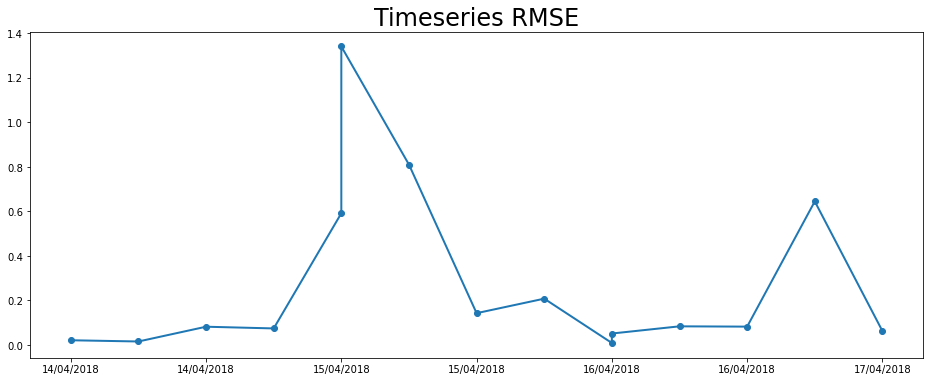

In [27]:
# forecast_df

fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Timeseries RMSE', fontdict = {'size':24});
plt.plot(
        analysis_df.index,
        analysis_df.RMSE,
        '-o',
        lw = 2,
)

# Formatar data
date_format = mdates.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(date_format)

plt.show()

### MAPAS

In [28]:
# dados que serão plotados
final_forecast_analysis_df.head(6)

,lat,lon,date,hour_bins,RMSE,dist
date,,,,,,
2018-04-14 00:00:00,-25.29401,-52.993698,2018-04-14 00:00:00,0.0,0.965100,6.590155
2018-04-14 06:00:00,-25.29401,-52.993698,2018-04-14 06:00:00,1.0,2.416902,6.590155
2018-04-14 12:00:00,-25.29401,-52.993698,2018-04-14 12:00:00,2.0,0.978695,6.590155
2018-04-14 18:00:00,-25.29401,-52.993698,2018-04-14 18:00:00,3.0,1.070464,6.590155
2018-04-15 00:00:00,-25.29401,-52.993698,2018-04-15 00:00:00,4.0,0.107753,6.590155
2018-04-15 00:00:00,-25.29401,-52.993698,2018-04-15 00:00:00,0.0,1.541051,6.590155


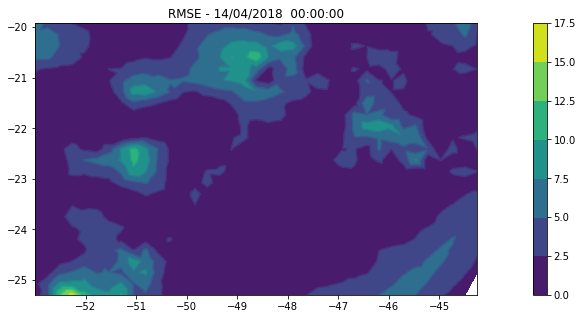

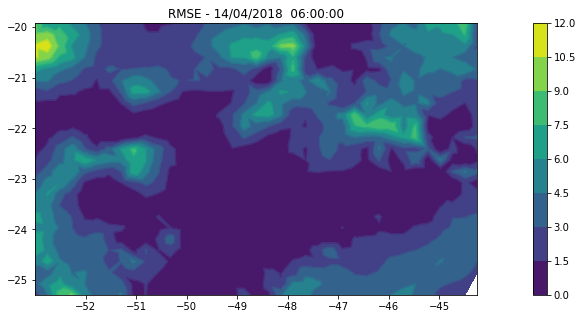

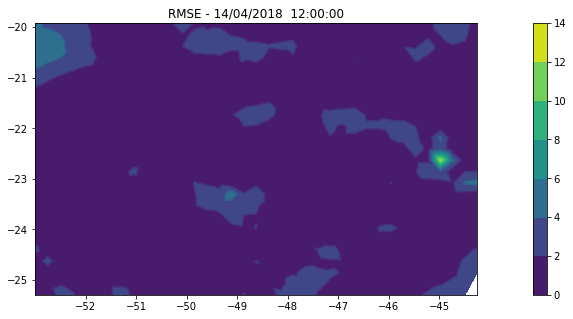

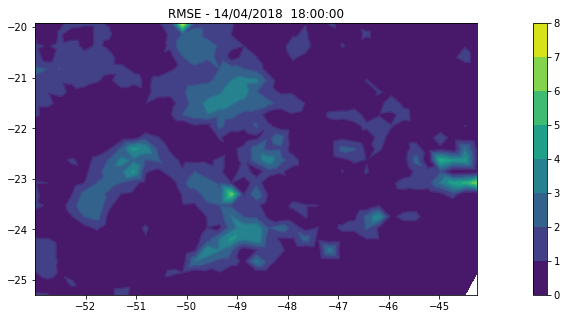

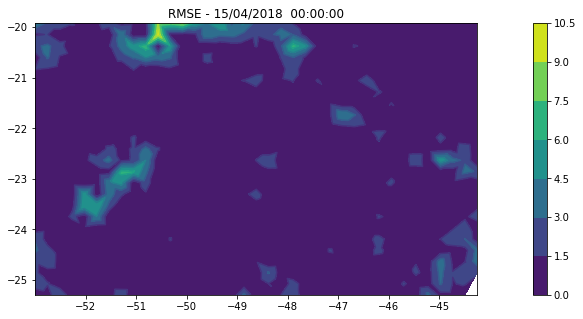

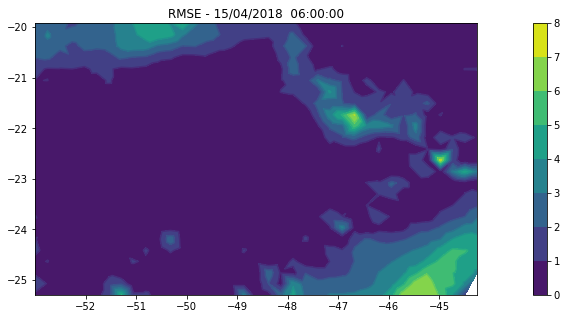

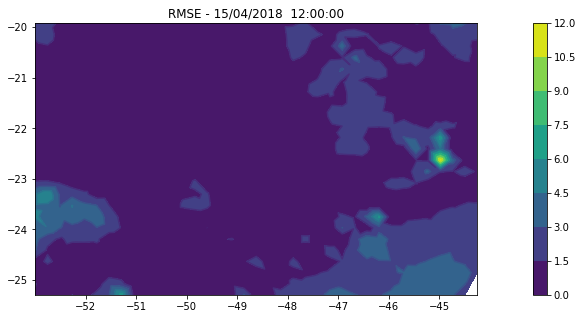

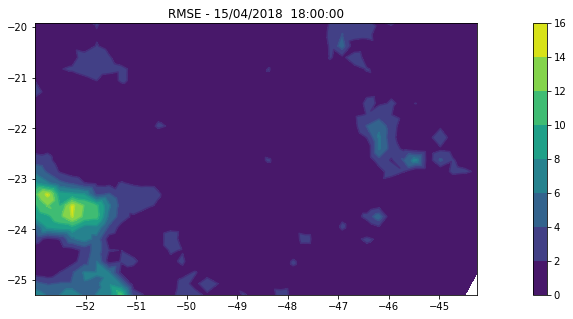

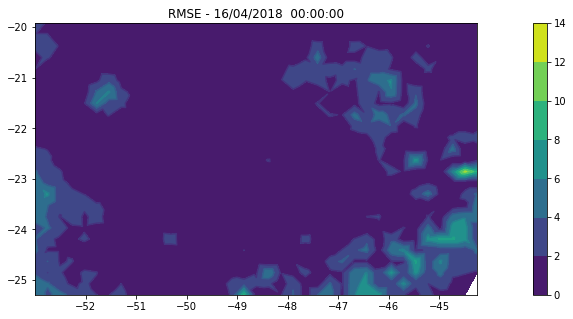

In [ ]:
from mpl_toolkits.basemap import Basemap

for date in final_forecast_analysis_df.date.unique():
    
    date_mask = final_forecast_analysis_df['date'] == date
    
    y = final_forecast_analysis_df.loc[date_mask,'lat'].values
    x = final_forecast_analysis_df.loc[date_mask,'lon'].values

    triang = tri.Triangulation(x, y)
    z = final_forecast_analysis_df.loc[date_mask,'RMSE'].values
    fig1, ax1 = plt.subplots(figsize = (20,5))
    ax1.set_aspect('equal')
    tcf = ax1.tricontourf(triang, z)
    fig1.colorbar(tcf)
    ax1.tricontour(triang, z)
    ax1.set_title(f'RMSE - {pd.to_datetime(date).strftime("%d/%m/%Y  %H:%M:%S")}')
    plt.show()